In [2]:
#autoreload
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from transformer_model import *
from viz import *
from dataset import *
from data import *

In [4]:

df = load_tload('data/buildings/datasets/2024/GATES_zone-tloads.csv')
weather = load_weather('data/buildings/datasets/2024/weather.csv')

In [5]:
weather = weather[weather.index.isin(df.index)]

In [6]:
import pandas as pd
import numpy as np

def add_temporal_features(dataframe):
    dataframe = dataframe.copy()
    
    # Convert the DatetimeIndex to a Series to use the dt accessor
    datetime_series = dataframe.index.to_series()
    
    # Add cyclic encoding for hour of the day
    dataframe['hour_sin'] = np.sin(2 * np.pi * datetime_series.dt.hour / 24)
    dataframe['hour_cos'] = np.cos(2 * np.pi * datetime_series.dt.hour / 24)
    
    return dataframe

# Adding temporal features to weather data
weather = add_temporal_features(weather)


In [7]:
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

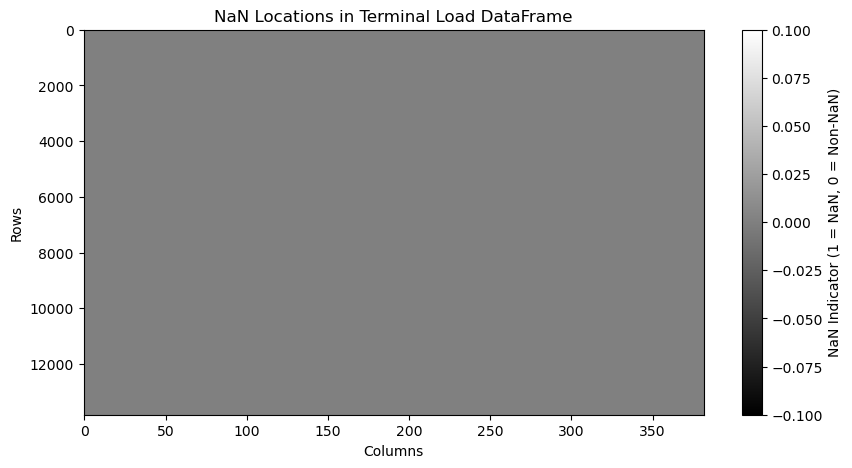

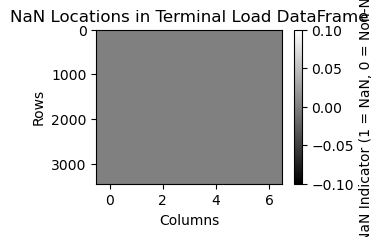

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [9]:
nan_viz(df, wide=True)
nan_viz(weather)

In [14]:
df.dropna(inplace=True)

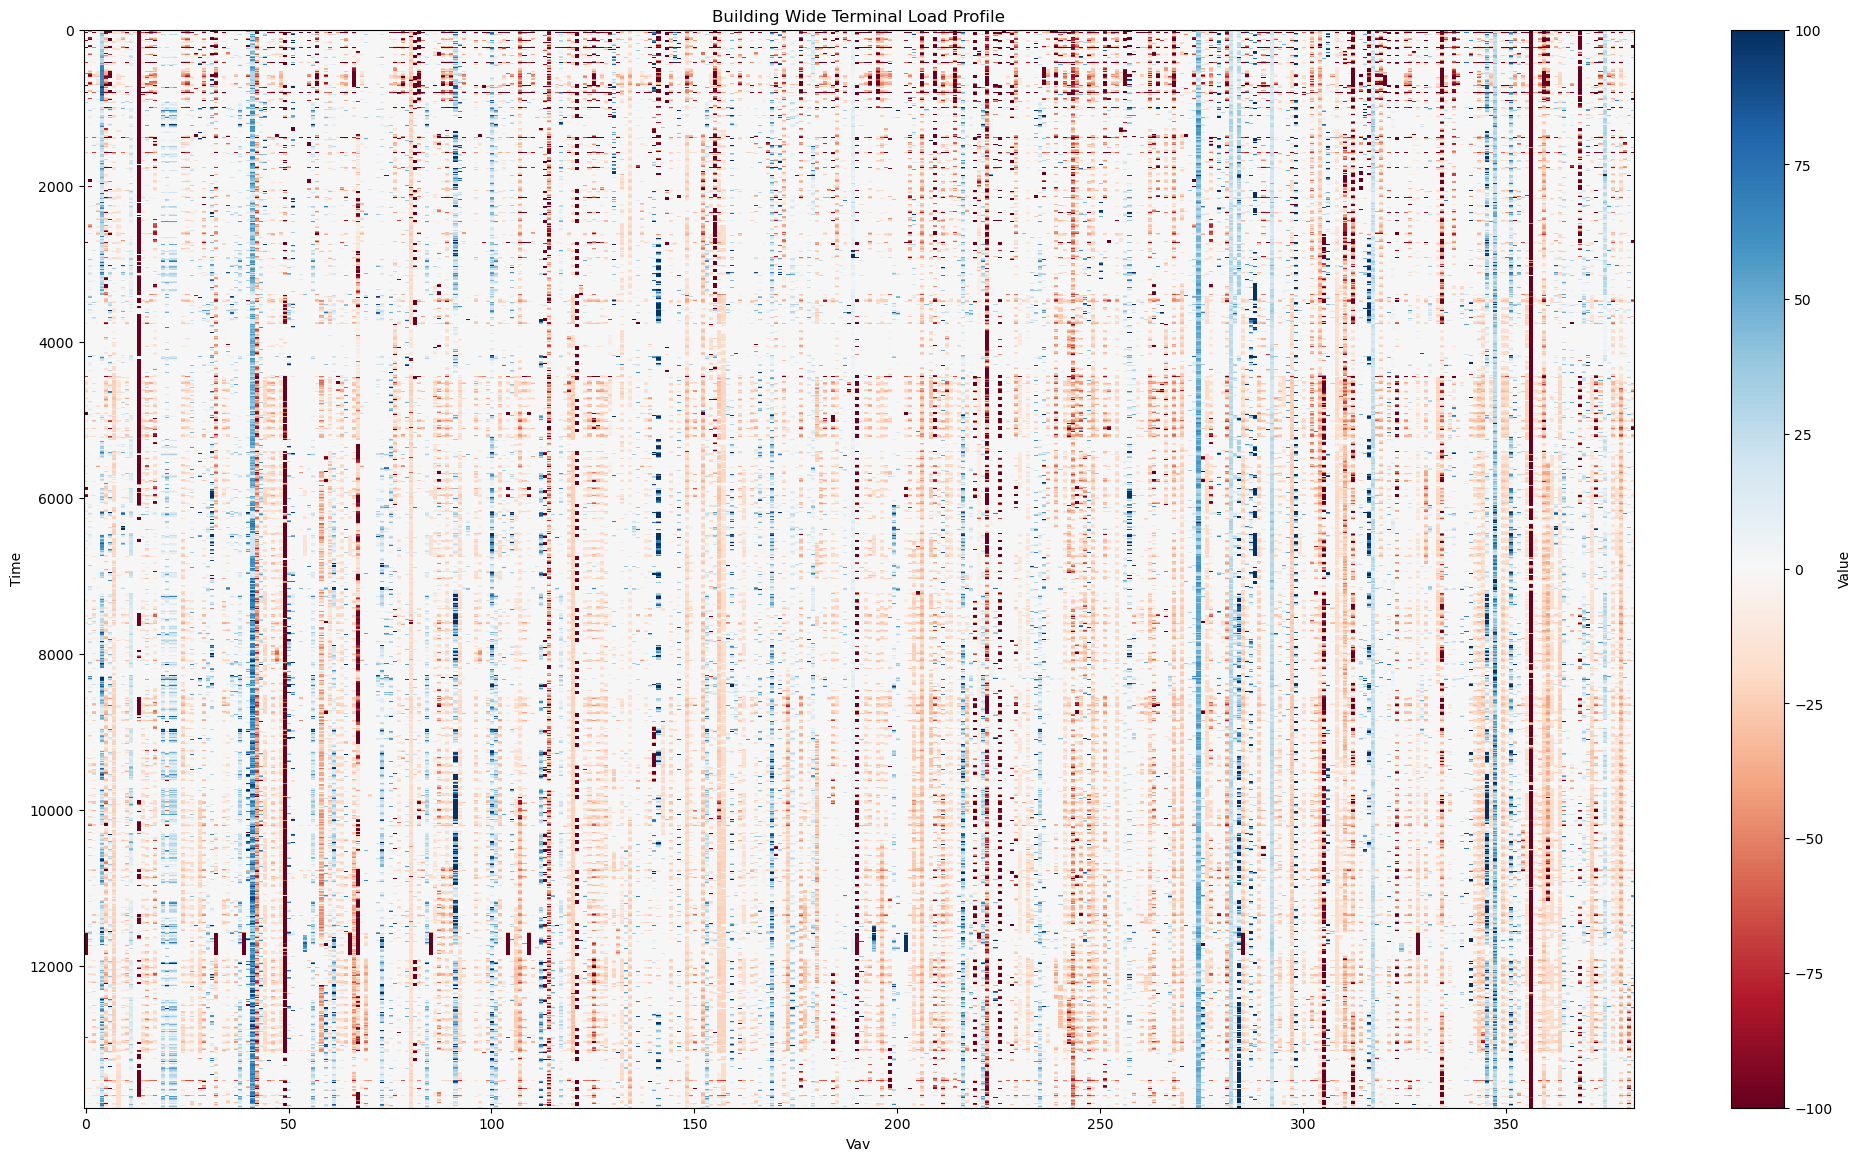

In [15]:
tload_viz(df)

We have time series for a given building, corresponding do each zone terminal load, a measure of how needy a zone i in term of cooling or reheat. 

We'll denote this:

$$T_{load}^{(z,t)}$$

With $t$ indexing the time and $z$ denoting the zone of the building. We have  382  zone in this building, which makes a vector of 
$$T_{load, building}^{t} \in \mathbb R ^{(382,1)}$$

We also have a input feature timeseries, which is common for all the building as well. This includes features such as Outside Air temperautre or solar irradiation. 

$$W^{t}$$

In the code the weather dataframe is formatted like so:
| Date                | temperature | RH  | Tdew | wind | sun_rad | daily_rain |
|---------------------|-------------|-----|------|------|---------|------------|
| 2023-05-01 00:00:00 | 52.6        | 75.0| 44.8 | 9.2  | 0.0     | 0.00       |
| 2023-05-01 01:00:00 | 52.4        | 75.0| 44.7 | 7.4  | 0.0     | 0.00       |
| 2023-05-01 02:00:00 | 52.2        | 75.0| 44.4 | 9.0  | 0.0     | 0.00       |

And the 

| Date                | VAV2-33 | VAV2-17   | VAV3-18 | VAV4-22    | VAV2-20 | VAV1-18 | VAV2-03   | VAV3-06 | VAV2-31 | VAV2-29 | ... | VAV2-11 | VAV2-32 | VAV4-25    | VAV4-08 | VAV1-02   | VAV0-00-4  | VAV0-04 | VAV1-12 | VAV2-18 | VAV3-15 |
|---------------------|---------|-----------|---------|------------|---------|---------|-----------|---------|---------|---------|-----|---------|---------|------------|---------|-----------|------------|---------|---------|---------|---------|
| 2023-05-01 00:00:00 | 0.0     | 0.000000  | 0.0     | -10.687083 | 0.0     | 0.0     | -5.494500 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.662916 | 0.0     | -0.435333 | -8.518917  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 01:00:00 | 0.0     | -0.355917 | 0.0     | -10.881667 | 0.0     | 0.0     | -7.798417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.492833 | 0.0     | -7.894917 | -7.576250  | 0.0     | 0.0     | 0.0     | 0.000000|
| 2023-05-01 02:00:00 | 0.0     | -0.559250 | 0.0     | -10.827083 | 0.0     | 0.0     | -6.123417 | 0.000000| 0.0     | -100.0  | ... | 0.0     | 0.0     | -16.670916 | 0.0     | -6.497750 | -8.176333  | 0.0     | 0.0     | 0.0     | -1.364750|

I want to train a LSTM architecture that will for an input of the past 2 weeks of data of terminal load vector, will try to predict the next week. I also have the exact weather for the two past weeks and the predicting wek (that could be a forcecast in real life use), to help the prediction of model, as those should be correlated in some ways. 

Give me a way to start formatting my code to have such a model, train it and test it. I want to have september has my validation set. 


# Quick look at the data

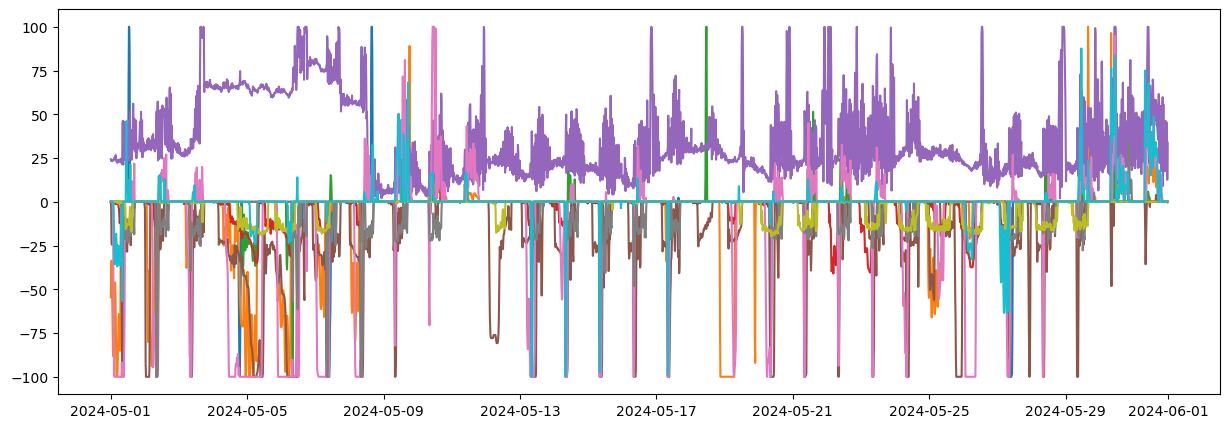

In [16]:
plt.figure(figsize=(15,5))
for col in df.columns[:10]:
    plt.plot(df.loc[df.index.month == 5,col], label=col)

# Hyperparameters choice

In [36]:
n_epochs = 400 

# Base model

In [55]:
from transformer_model import get_trained_model

In [56]:
# Make sure both dataframes have datetime indices
df.index = pd.to_datetime(df.index)
weather.index = pd.to_datetime(weather.index)

# Train the model
model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader = get_trained_model(df, weather, n_epochs=n_epochs)

Checking data availability...
Terminal loads date range: 2024-04-29 00:00:00 to 2024-09-19 23:45:00
Weather data date range: 2024-04-29 00:00:00 to 2024-09-19 23:00:00

Using split date: 2024-08-21 00:00:00

Checking data sizes:
Training set hours: 10942
Validation set hours: 2880
Minimum required hours: 192

Creating datasets...
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)

Creating dataloaders...

Initializing model...

Starting training...
Epoch [1/400], Train Loss: 0.9013, Val Loss: 1.0021, LR: 0.000010
Epoch [2/400], Train Loss: 0.8590, Val Loss: 1.0000, LR: 0.000010
Epoch [3/400], Train Loss: 0.8875, Val Loss: 0.9980, LR: 0.000010
Epoch [4/400], Train Loss: 0.8749, Val Loss: 0.9958, LR: 0.000010
Epoch [5/400], Train Loss: 0.9233, Val Loss: 0.9936

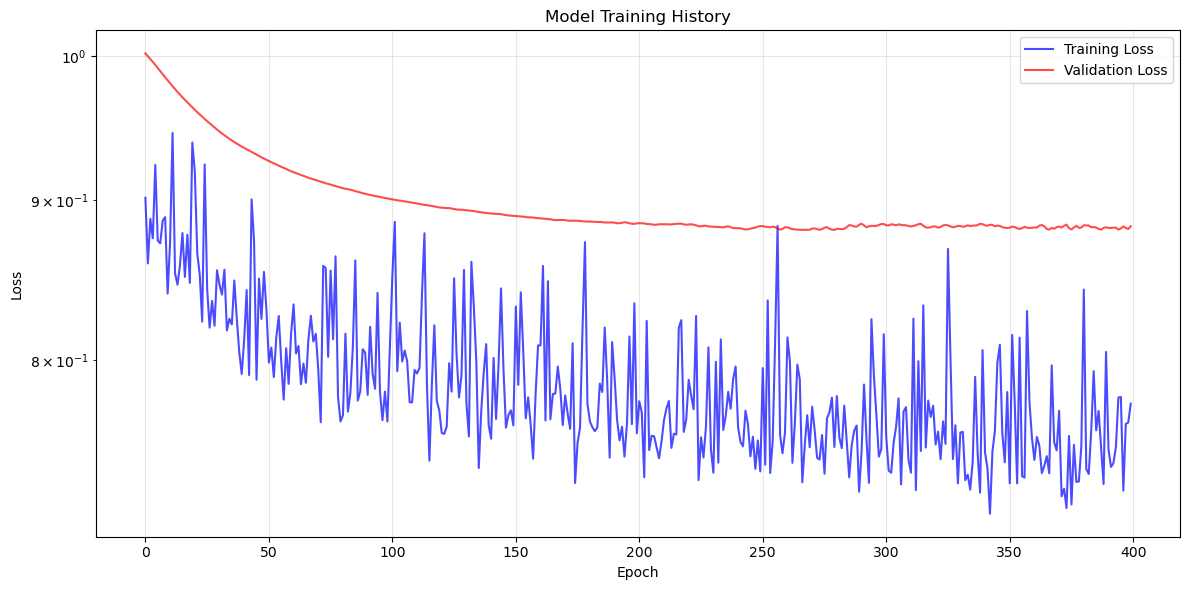

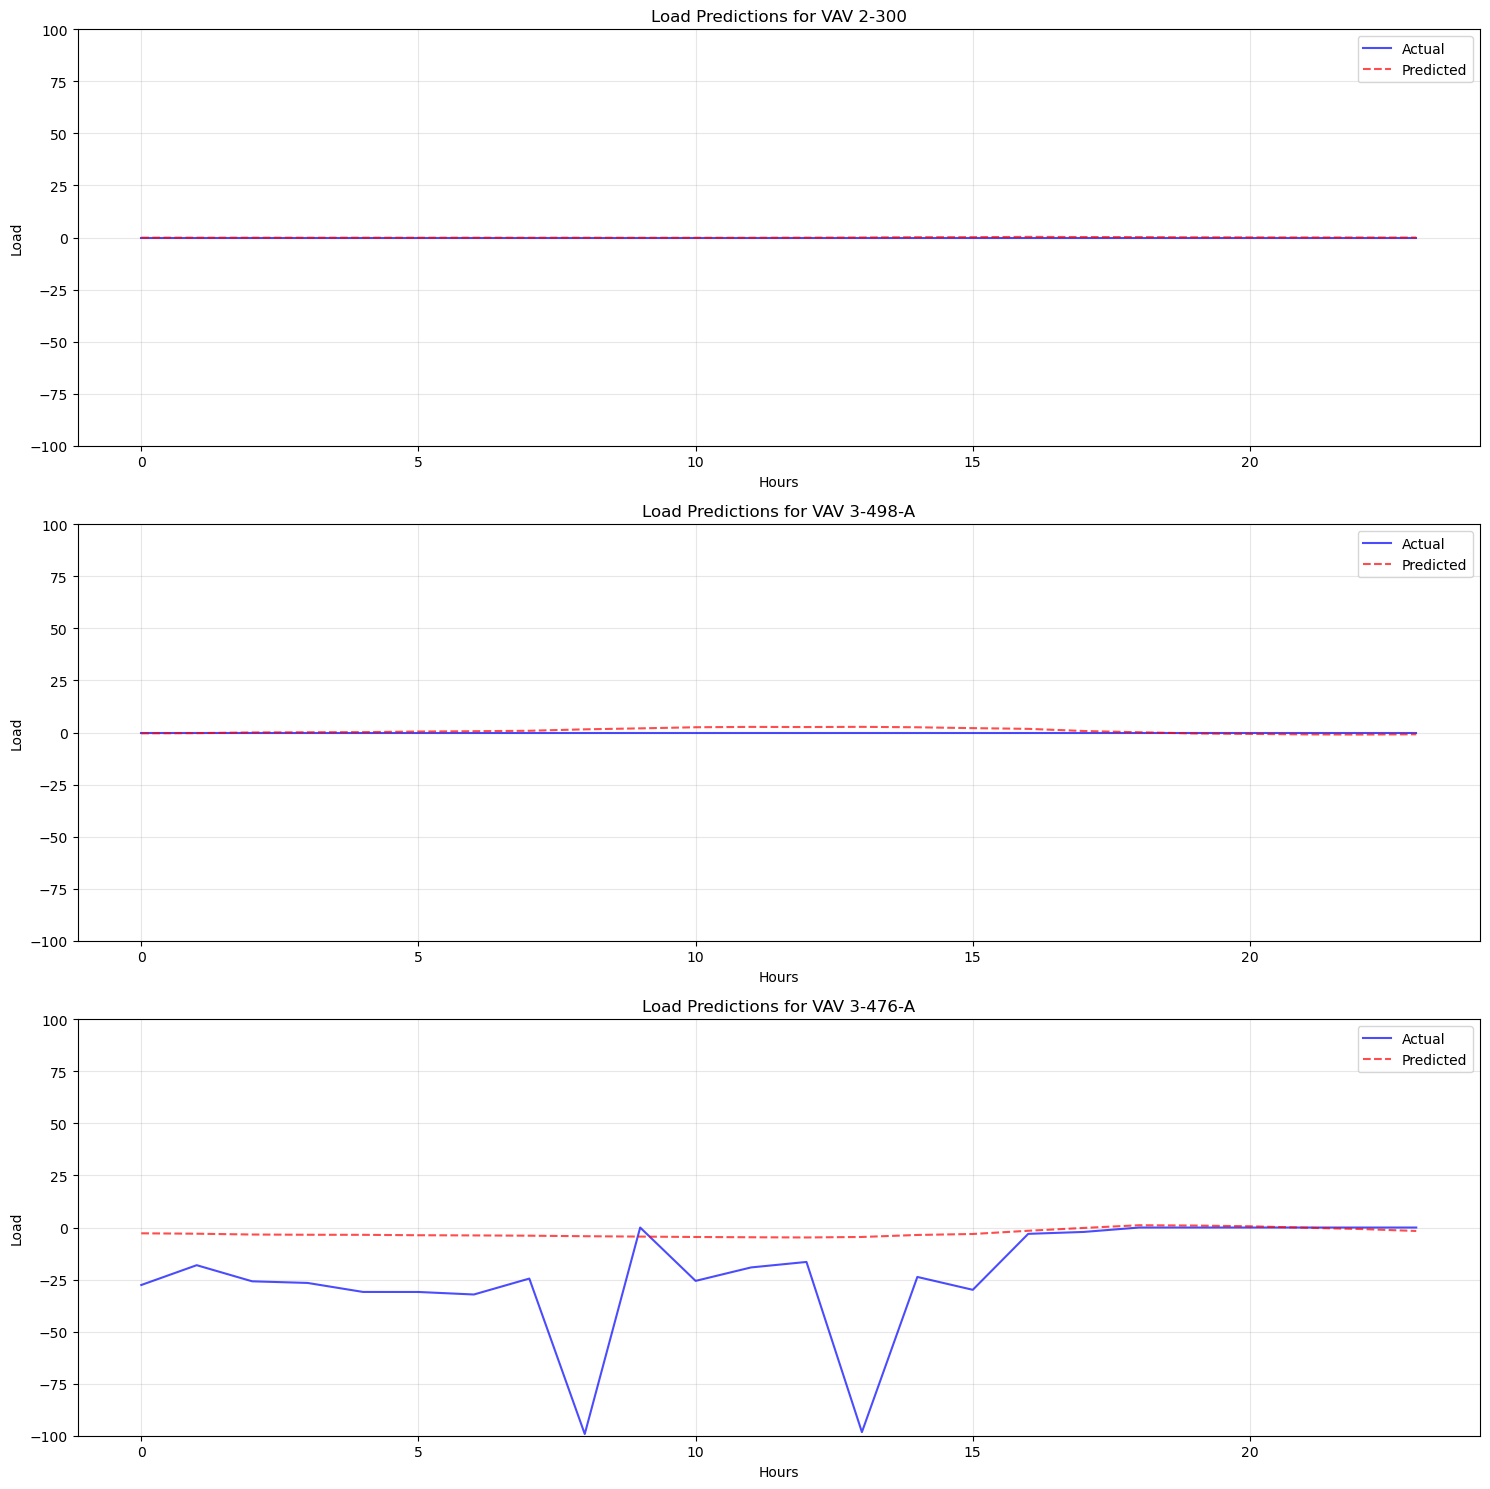

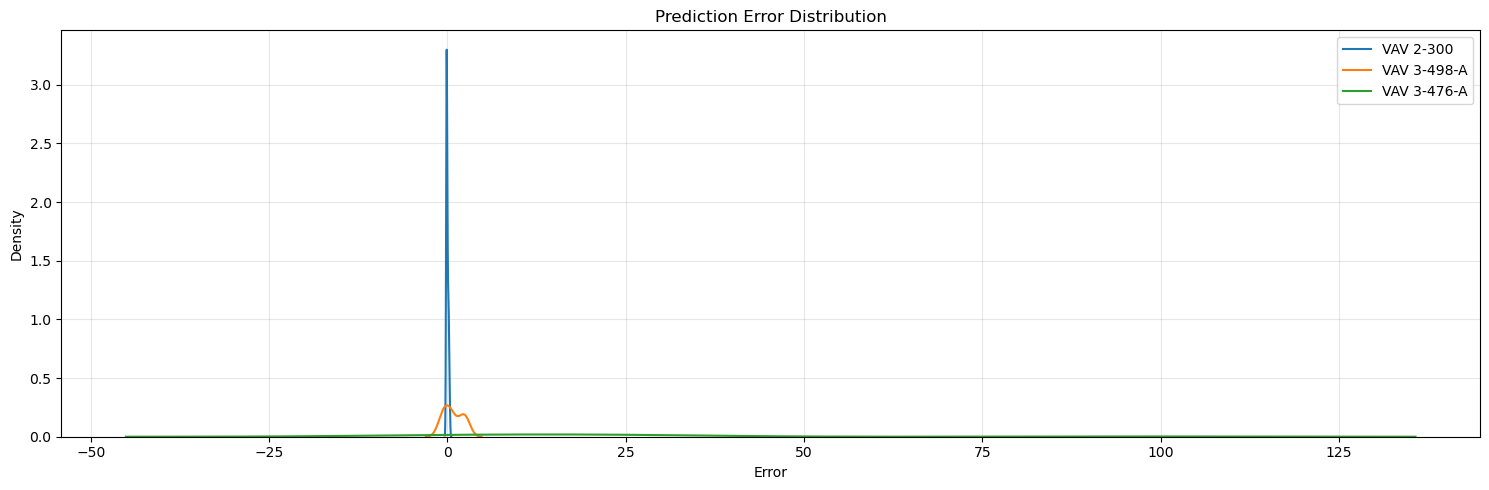


Prediction Metrics:
--------------------------------------------------

VAV 2-300:
MAPE: 11630807200.00%
RMSE: 0.13

VAV 3-498-A:
MAPE: 2942409600.00%
RMSE: 1.50

VAV 3-476-A:
MAPE: 26244036800.00%
RMSE: 31.87


In [57]:
# Correct way to call visualize_results
visualize_results(
    model=model,
    dataset=train_dataset,  # The dataset object
    load_scaler=train_dataset.load_scaler,  # The actual scaler object
    train_losses=train_losses,
    val_losses=val_losses,
    zones_names=df.columns,
    sample_idx=0,
    n_samples=3,
)

In [60]:
import torch
import pickle
from transformer_model import save_all, load_all
# Example usage
model_path = 'model/model2.pth'
data_path = 'model/data2.pkl'
save_all(model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader, model_path, data_path)

In [10]:
model_path = 'model/model2.pth'
data_path = 'model/data2.pkl'
model, train_losses, val_losses, train_dataset, val_dataset, train_loader, val_loader = load_all(model_path, data_path)

/Users/alexisbonnafont/Documents/CS230/Deep_Building/transformer_model.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# Error Analysis

In [171]:
all_errors, all_predictions, all_targets = calculate_errors(model, val_dataset, val_dataset.load_scaler)

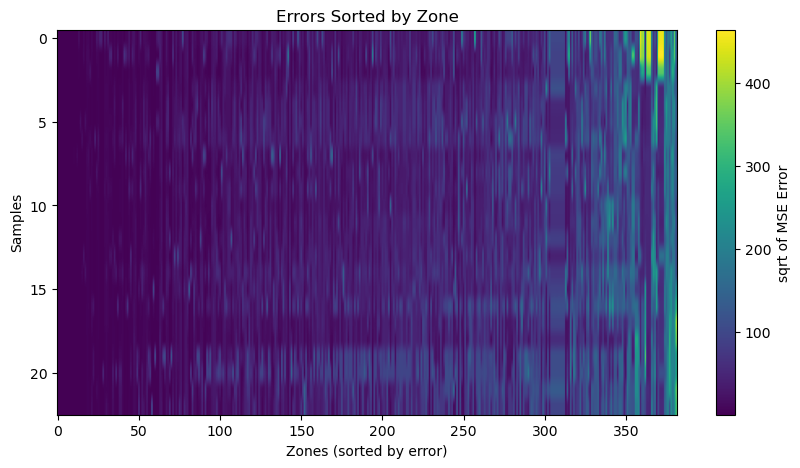

[ 0 17 16]


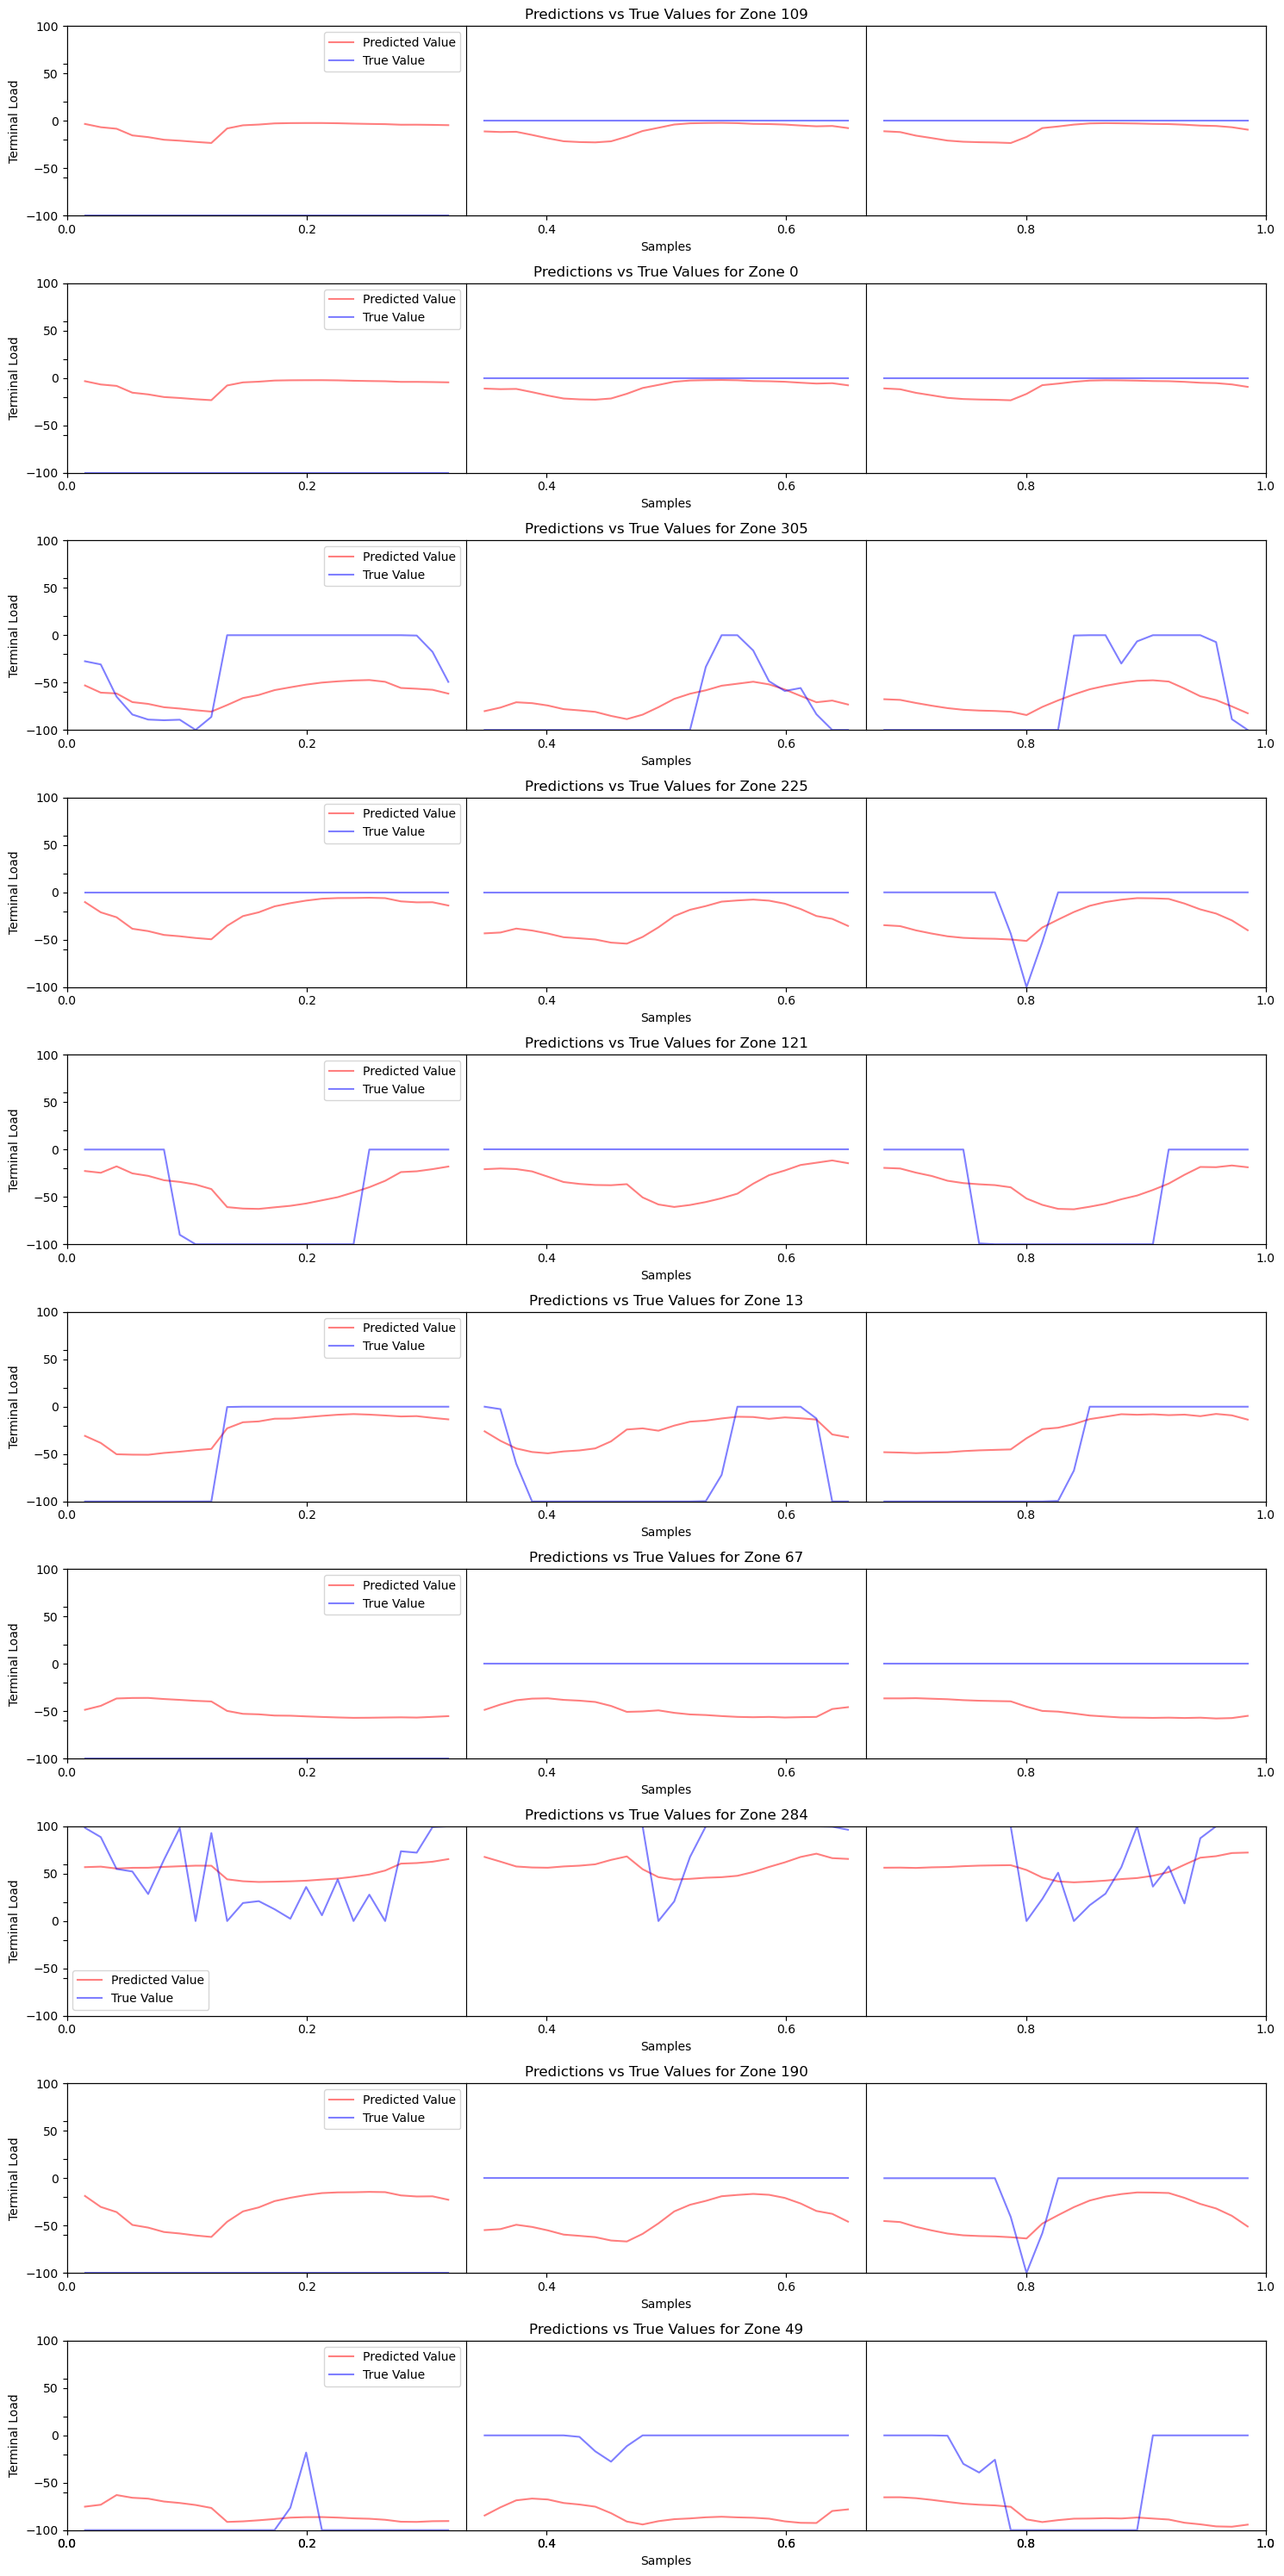

[15 16 11]


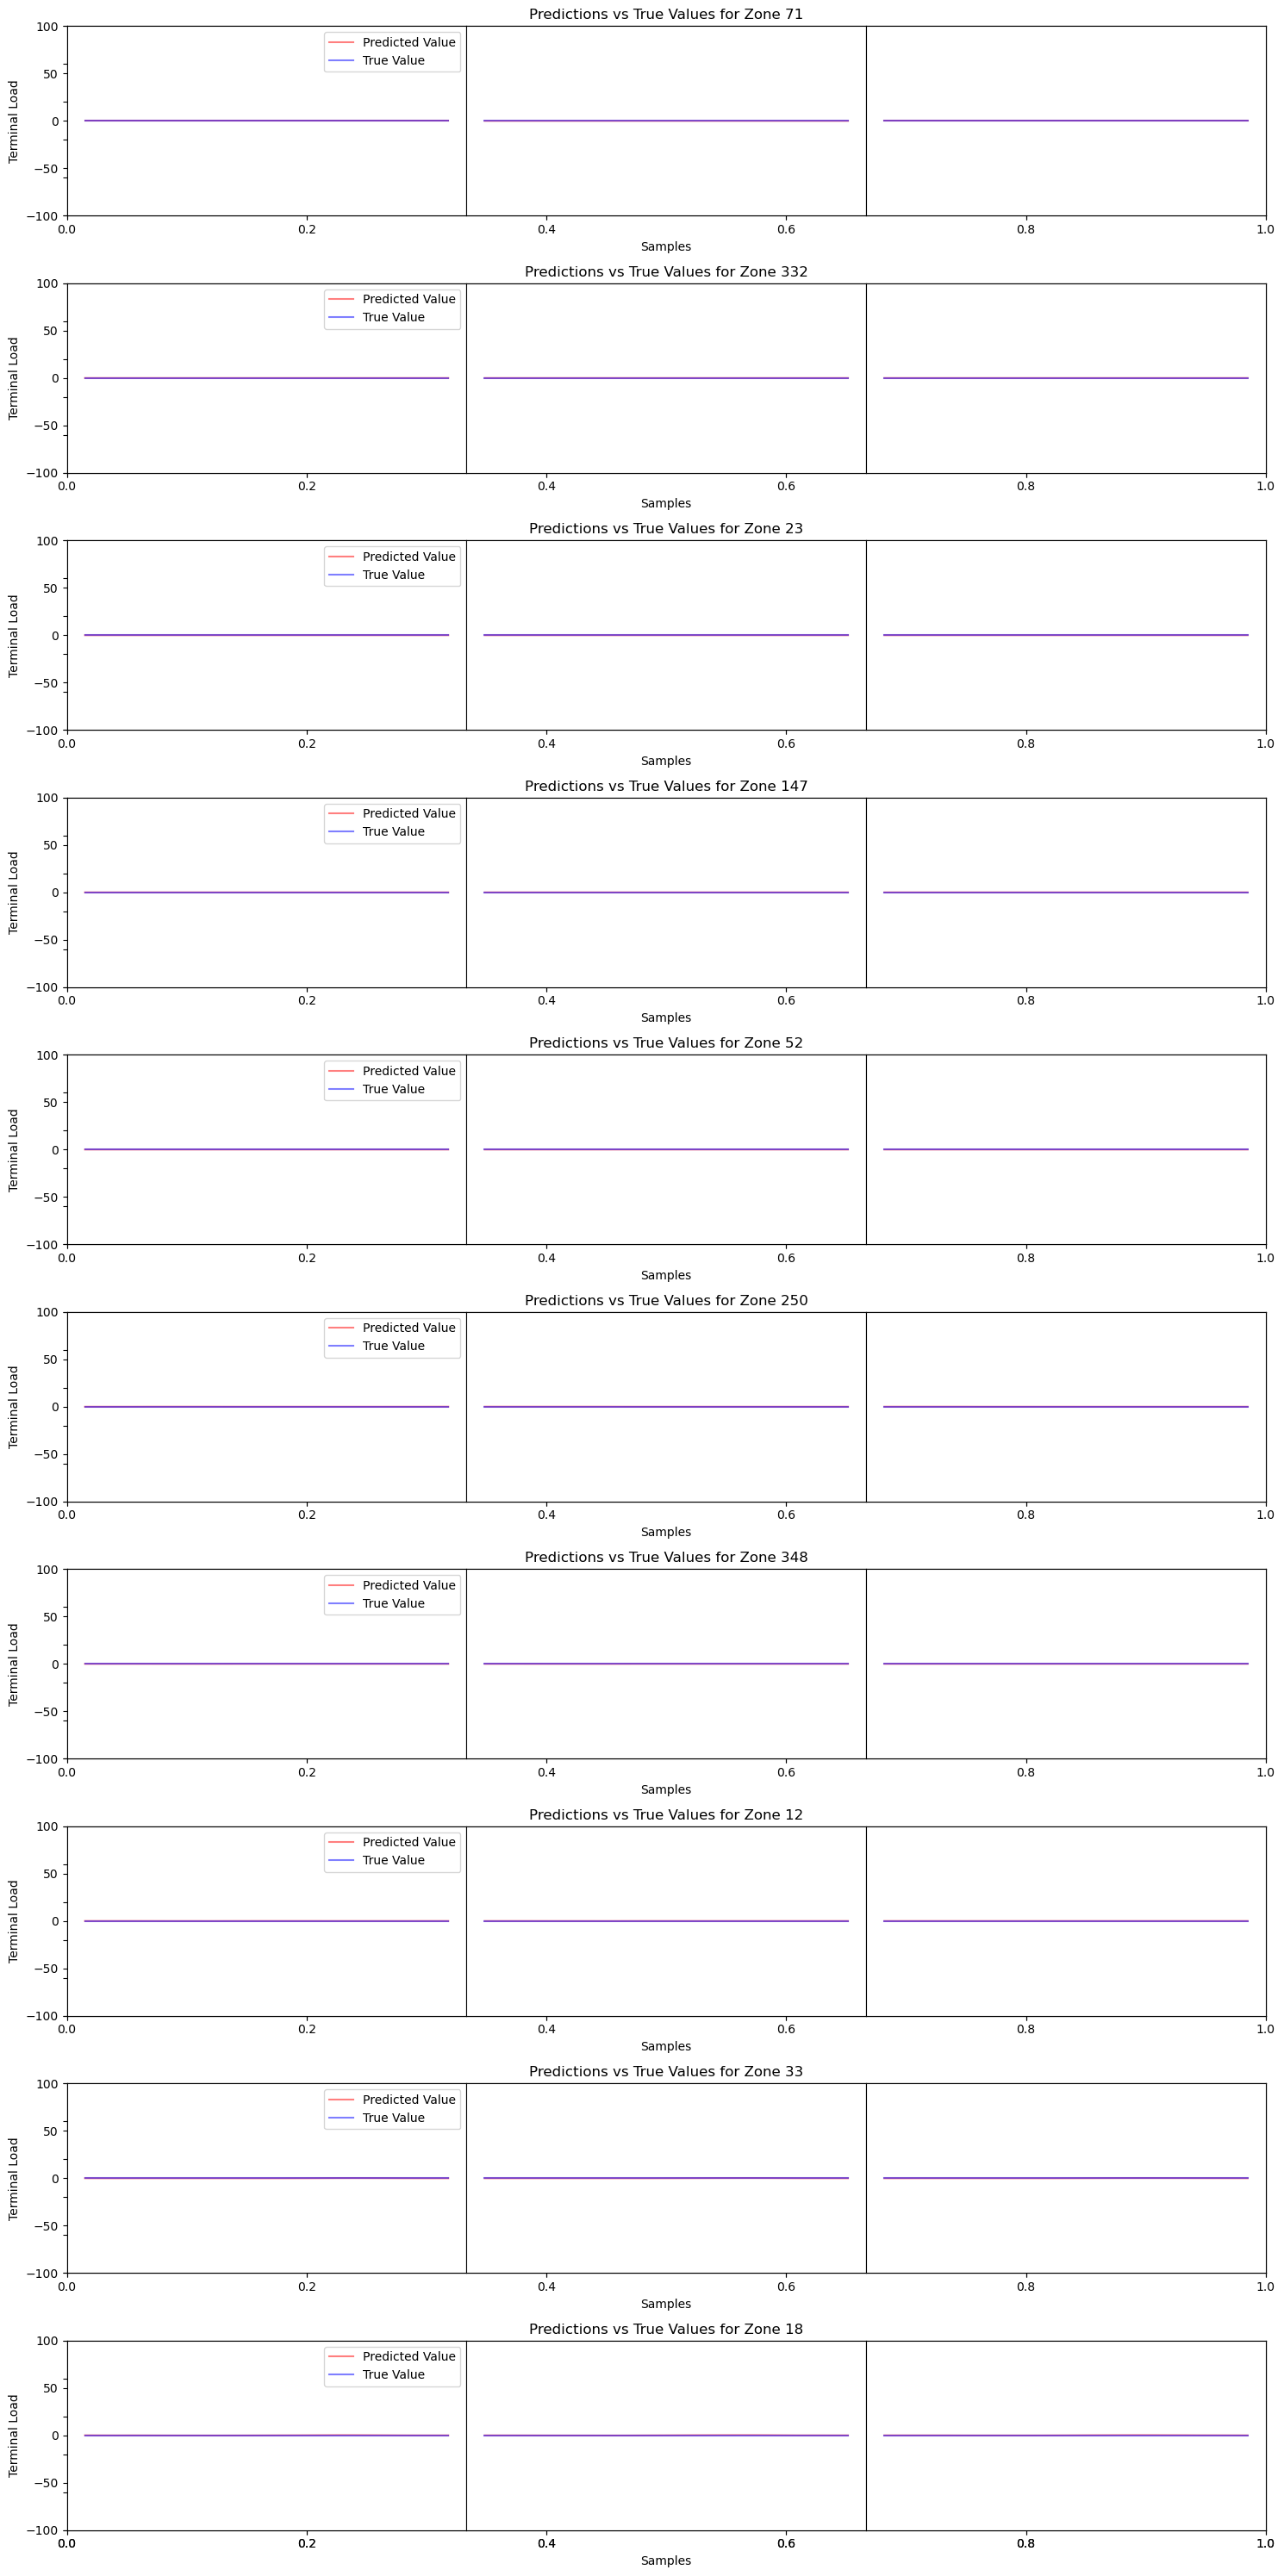

In [63]:
from viz import plot_dataset_error, plot_bad_samples_predictions

plot_dataset_error(all_errors)

plot_bad_samples_predictions(all_errors, all_predictions, all_targets, N_samples=3, N_zones=10)
plot_bad_samples_predictions(all_errors, all_predictions, all_targets, good_zones=True,N_samples=3, N_zones=10)

In [159]:
weather_df

temperature    RH  Tdew  wind  sun_rad
Date                                                       
2024-04-29 00:00:00        105.7  73.0  47.3   7.0      0.0
2024-04-29 01:00:00        105.5  71.0  46.4   8.8      0.0
2024-04-29 02:00:00        104.9  71.0  45.7   6.2      0.0
2024-04-29 03:00:00        102.8  77.0  45.7   3.0      0.0
2024-04-29 04:00:00         98.9  87.0  45.3   1.8      0.0
...                          ...   ...   ...   ...      ...
2024-09-19 19:00:00        116.2  75.0  58.2   4.8     86.0
2024-09-19 20:00:00        113.0  78.0  56.1   4.0      2.0
2024-09-19 21:00:00        110.4  84.0  55.7   3.1      0.0
2024-09-19 22:00:00        109.4  87.0  55.7   2.5      0.0
2024-09-19 23:00:00        108.1  93.0  56.1   1.3      0.0

[3454 rows x 5 columns]

In [185]:
val_dataset.normalized_weather

temperature        RH      Tdew      wind   sun_rad
2024-08-21 00:00:00    -0.497429  0.187896 -0.654627 -0.358640 -0.794474
2024-08-21 01:00:00    -0.660674  0.305689 -0.884643 -0.127342 -0.794474
2024-08-21 02:00:00    -0.736855  0.246793 -1.172163 -0.173602 -0.794474
2024-08-21 03:00:00    -0.932749  0.482378 -1.287171 -0.821234 -0.794474
2024-08-21 04:00:00    -0.976281  0.364586 -1.574691  0.011436 -0.794474
...                          ...       ...       ...       ...       ...
2024-09-19 19:00:00     0.112019  0.011207  0.639213  0.381512 -0.525648
2024-09-19 20:00:00    -0.236237  0.187896  0.035421  0.011436 -0.788222
2024-09-19 21:00:00    -0.519195  0.541275 -0.079587 -0.404899 -0.794474
2024-09-19 22:00:00    -0.628025  0.717964 -0.079587 -0.682456 -0.794474
2024-09-19 23:00:00    -0.769504  1.071343  0.035421 -1.237570 -0.794474

[720 rows x 5 columns]

In [11]:
terminal_loads_df = df.copy()

weather_df = weather.copy()
for col in weather_df.columns:
    weather_df[col] += 100
#for col in terminal_loads_df.columns:
#    terminal_loads_df[col] += 100
    
# Calculate the split date dynamically to ensure we have enough data for both sets
total_days = (terminal_loads_df.index.max() - terminal_loads_df.index.min()).days
split_days = int(total_days * 0.8)  # 80% for training
split_date = terminal_loads_df.index.min() + pd.Timedelta(days=split_days)

print(f"\nUsing split date: {split_date}")

# Split data into train and validation sets
train_loads = terminal_loads_df[terminal_loads_df.index < split_date]
train_weather = weather_df[weather_df.index < split_date]

val_loads = terminal_loads_df[terminal_loads_df.index >= split_date]
val_weather = weather_df[weather_df.index >= split_date]

# Check if we have enough data in each set
min_required_hours = INPUT_WINDOW + OUTPUT_WINDOW  # Input window + output window

print("\nChecking data sizes:")
print(f"Training set hours: {len(train_loads)}")
print(f"Validation set hours: {len(val_loads)}")
print(f"Minimum required hours: {min_required_hours}")

if len(train_loads) < min_required_hours or len(val_loads) < min_required_hours:
    raise ValueError(
        f"Insufficient data for training/validation. Need at least {min_required_hours} "
        f"continuous hours in each set. Got {len(train_loads)} training hours and "
        f"{len(val_loads)} validation hours."
    )

print("\nCreating datasets...")
train_dataset = TerminalLoadDataset(train_loads, train_weather)
val_dataset = TerminalLoadDataset(val_loads, val_weather)

if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError(
        f"No valid sequences created. Got {len(train_dataset)} training sequences "
        f"and {len(val_dataset)} validation sequences. Check for data gaps or "
        "missing values in your input data."
    )

print("\nCreating dataloaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



Using split date: 2024-08-21 00:00:00

Checking data sizes:
Training set hours: 10942
Validation set hours: 2880
Minimum required hours: 192

Creating datasets...
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)

Creating dataloaders...


In [241]:
from model import calculate_errors
all_errors, all_predictions, all_targets = calculate_errors(model, val_dataset, val_dataset.load_scaler)

In [242]:
concatenated_predictions = np.concatenate([all_predictions[sample] for sample in range(all_predictions.shape[0])], axis=0)
predictions_df = pd.DataFrame(concatenated_predictions, columns=df.columns)
predictions_df = predictions_df.map(lambda x: max(-100,x))
predictions_df.index = df.iloc[-concatenated_predictions.shape[0]:].index
predictions_df

VAV 2-119-C  VAV 3-481-B  ...  VAV 3-190  VAV 1-326-B
Date                                           ...                        
2024-09-14 06:00:00    -3.336226     1.432839  ... -18.833311     7.157654
2024-09-14 06:15:00    -6.810413     0.238946  ... -18.224636     4.912141
2024-09-14 06:30:00    -8.307096    -1.636186  ... -19.459938     1.763800
2024-09-14 06:45:00   -15.475761    -2.467241  ... -20.794584    -0.910283
2024-09-14 07:00:00   -17.270420    -2.588423  ... -20.804880    -1.454725
...                          ...          ...  ...        ...          ...
2024-09-19 22:45:00    -4.680501     1.764699  ... -18.926710     7.393441
2024-09-19 23:00:00    -3.733281     0.090229  ... -19.717934     5.779346
2024-09-19 23:15:00    -5.159192    -0.721795  ... -20.143196     4.336901
2024-09-19 23:30:00    -7.856765    -0.814749  ... -21.250109     3.712568
2024-09-19 23:45:00    -9.578027    -0.993521  ... -21.378275     2.893638

[552 rows x 382 columns]

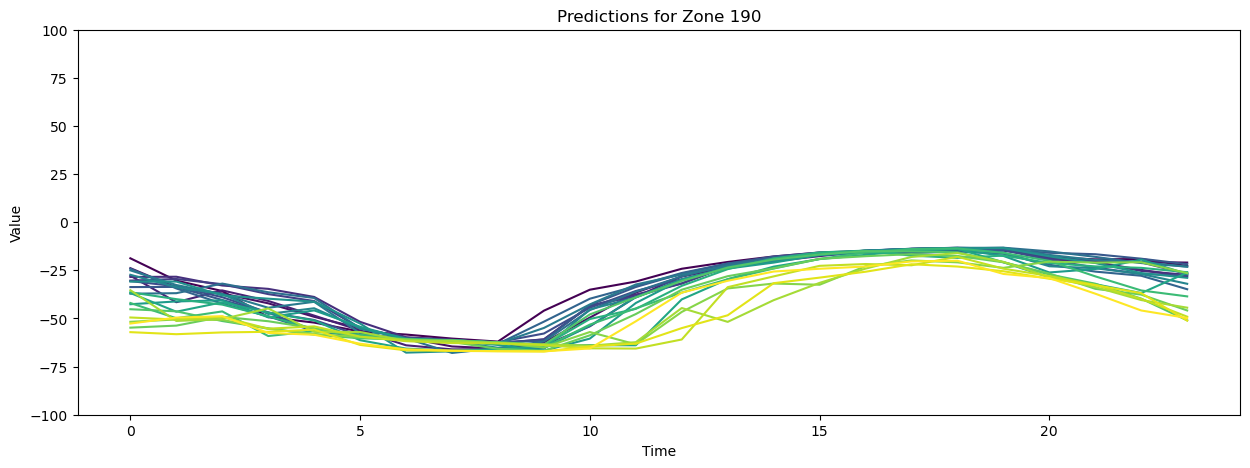

In [243]:

zone = 190
num_samples = all_predictions.shape[0]

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_samples))

plt.figure(figsize=(15, 5))
for sample in range(num_samples):
    plt.plot(all_predictions[sample, :, zone], color=colors[sample])

plt.ylim(-100, 100)
plt.title(f'Predictions for Zone {zone}')
plt.xlabel('Time')
plt.ylabel('Value')

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_samples-1))
sm.set_array([])

plt.show()

# Building wide prediction

In [172]:
all_errors, all_predictions, all_targets = calculate_errors(model, val_dataset, val_dataset.load_scaler)

In [130]:
all_errors.sum()

45560570.0

In [131]:
concatenated_predictions = np.concatenate([all_predictions[sample] for sample in range(all_predictions.shape[0])], axis=0)
concatenated_predictions.shape  

(552, 382)

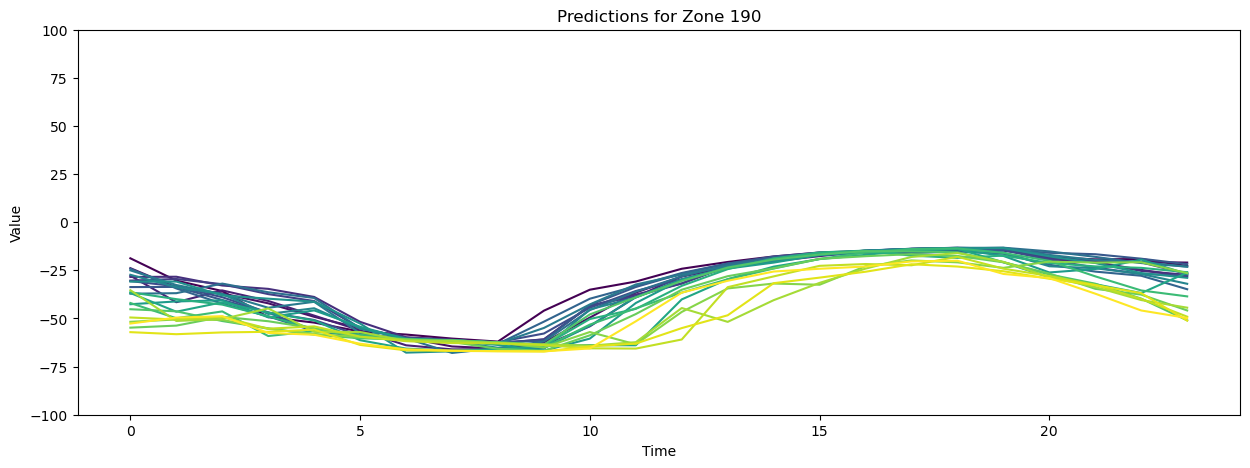

In [139]:
predictions_df = pd.DataFrame(concatenated_predictions, columns=df.columns)
predictions_df = predictions_df.map(lambda x: max(-100,x))
predictions_df.index = df.iloc[-concatenated_predictions.shape[0]:].index

-10000000.0

Using split date: 2024-08-21 00:00:00
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)

Creating dataloaders...
-7777777.777777778

Using split date: 2024-08-21 00:00:00
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)

Creating dataloaders...
-5555555.555555556

Using split date: 2024-08-21 00:00:00
Created 106 valid sequences
First sequence shapes:
Past terminal load and weather: (168, 389)
Future weather: (24, 7)
Target loads: (24, 382)
Created 23 valid sequences
First sequence shapes:
Past terminal load and we

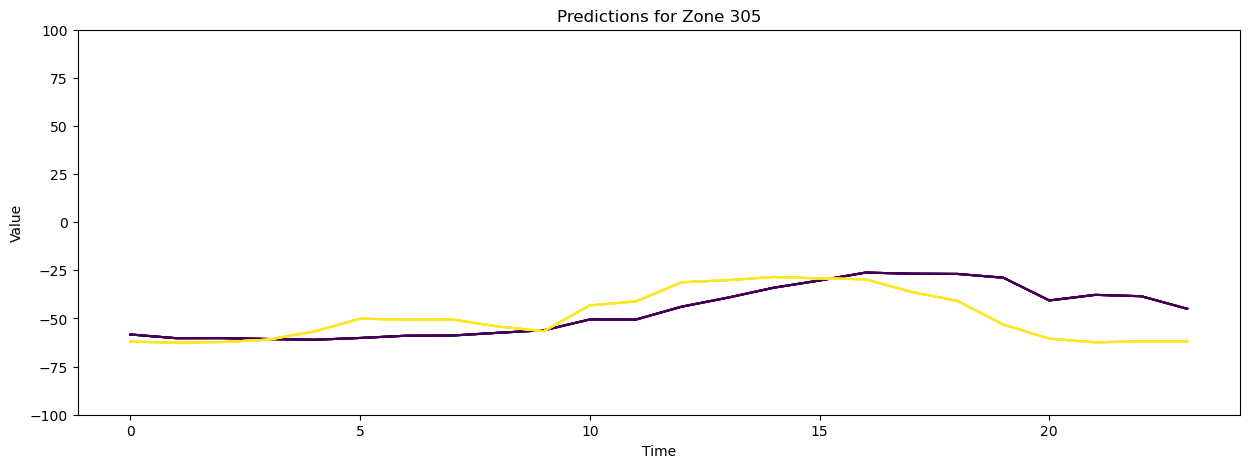

In [16]:

plt.figure(figsize=(15, 5))

# Create a colormap
factor_list = np.linspace(-1e7, 1e7, 10)
cmap = plt.get_cmap('viridis')
colors = cmap(factor_list) 
for i_factor, factor in enumerate(factor_list):
    print(factor)
    zone = 305 
    sample = 10
    terminal_loads_df = df.copy()

    weather_df = weather.copy()
    if factor > 0:
        weather_df["hour_cos"] = 0
    
    if factor > 1e3:
        weather_df["hour_sin"] = 0

    if factor > 1e6:
        weather_df["hour_cos"] = 0
        weather_df["hour_sin"] = 0
        
    #for col in terminal_loads_df.columns:
    #    terminal_loads_df[col] += 100
        
    # Calculate the split date dynamically to ensure we have enough data for both sets
    total_days = (terminal_loads_df.index.max() - terminal_loads_df.index.min()).days
    split_days = int(total_days * 0.8)  # 80% for training
    split_date = terminal_loads_df.index.min() + pd.Timedelta(days=split_days)

    print(f"\nUsing split date: {split_date}")

    # Split data into train and validation sets
    train_loads = terminal_loads_df[terminal_loads_df.index < split_date]
    train_weather = weather_df[weather_df.index < split_date]

    val_loads = terminal_loads_df[terminal_loads_df.index >= split_date]
    val_weather = weather_df[weather_df.index >= split_date]

    # Check if we have enough data in each set
    min_required_hours = INPUT_WINDOW + OUTPUT_WINDOW  # Input window + output window
    train_dataset = TerminalLoadDataset(train_loads, train_weather)
    val_dataset = TerminalLoadDataset(val_loads, val_weather)

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise ValueError(
            f"No valid sequences created. Got {len(train_dataset)} training sequences "
            f"and {len(val_dataset)} validation sequences. Check for data gaps or "
            "missing values in your input data."
        )

    print("\nCreating dataloaders...")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    from model import calculate_errors
    all_errors, all_predictions, all_targets = calculate_errors(model, train_dataset, train_dataset.load_scaler)
    concatenated_predictions = np.concatenate([all_predictions[sample] for sample in range(all_predictions.shape[0])], axis=0)
    predictions_df = pd.DataFrame(concatenated_predictions, columns=df.columns)
    predictions_df = predictions_df.map(lambda x: max(-100,x))
    predictions_df.index = df.iloc[-concatenated_predictions.shape[0]:].index


    num_samples = all_predictions.shape[0]


    plt.plot(all_predictions[sample, :, zone], color=colors[i_factor])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_samples-1))
    sm.set_array([])

plt.ylim(-100, 100)
plt.title(f'Predictions for Zone {zone}')
plt.xlabel('Time')
plt.ylabel('Value')

# Create a ScalarMappable and add the colorbar
    
plt.show()

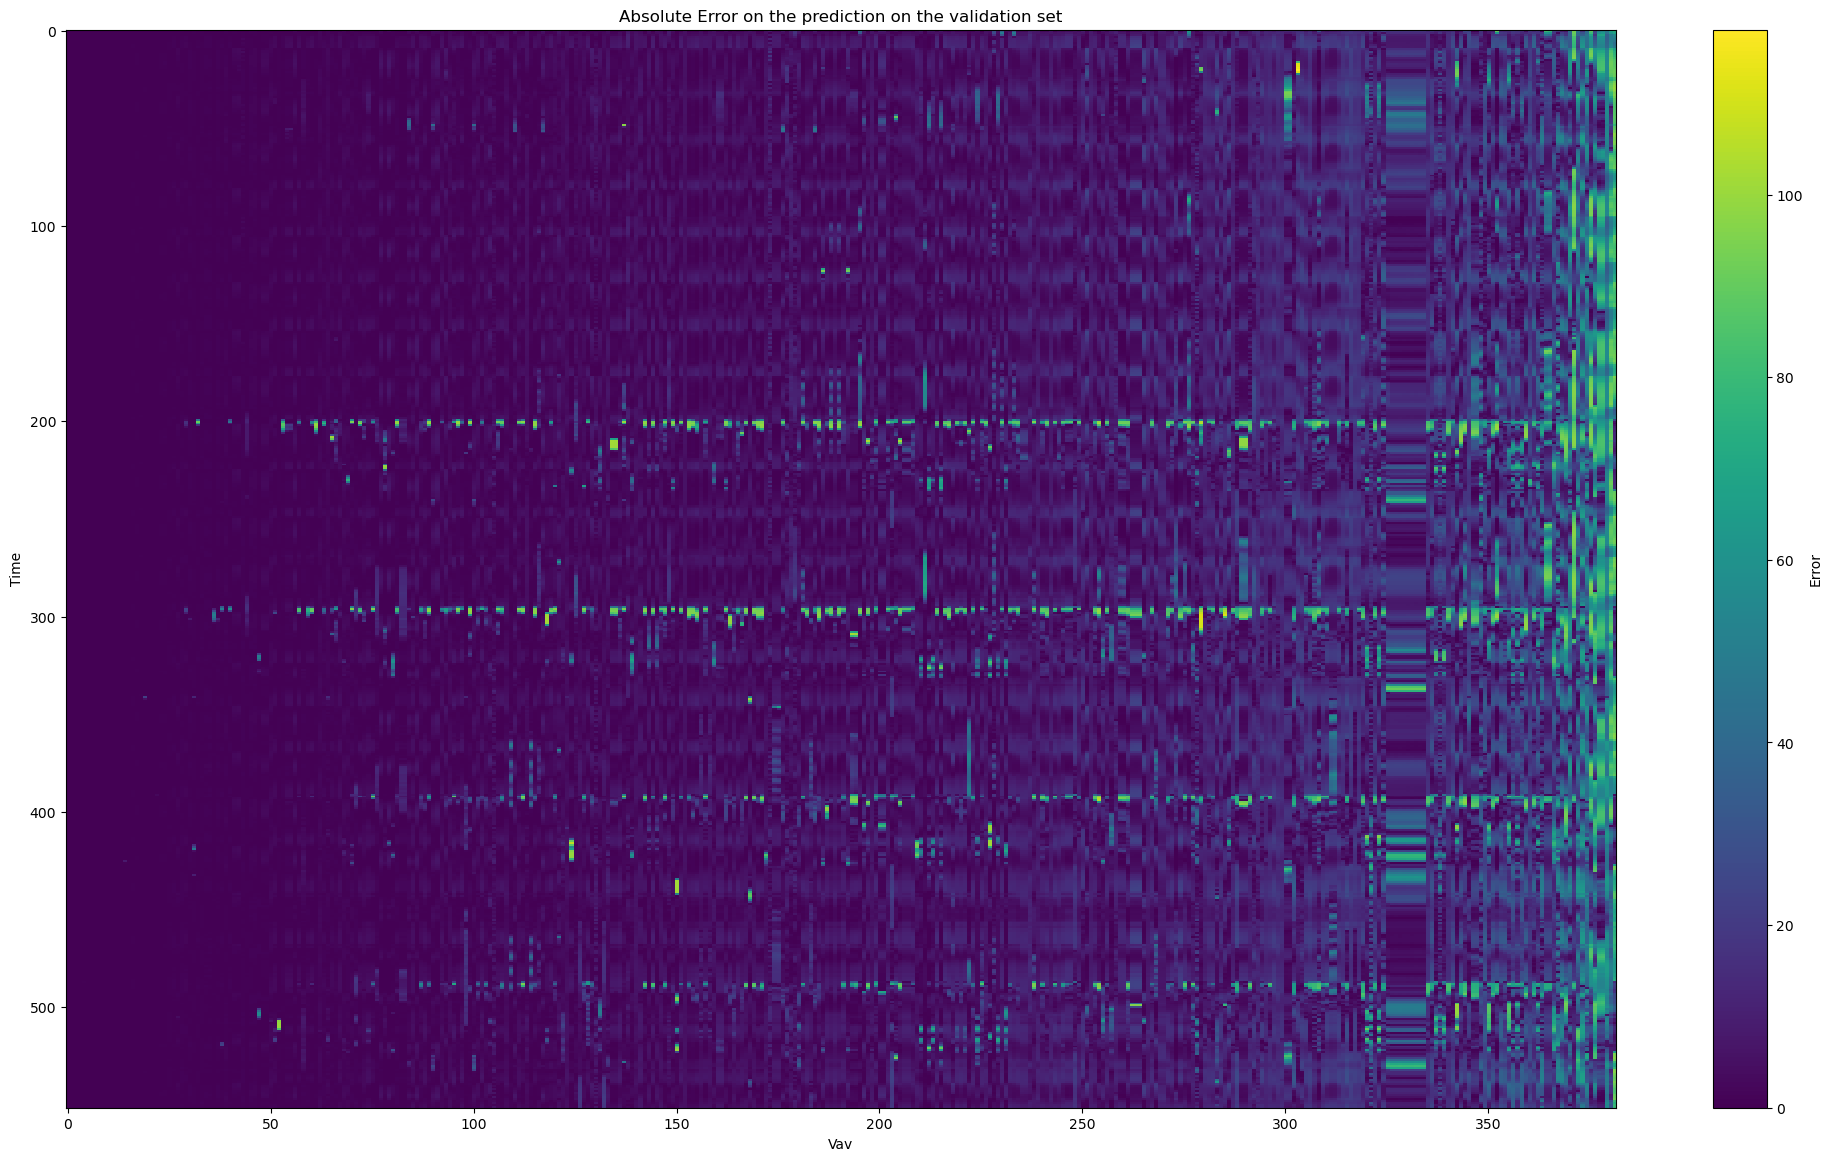

In [102]:
from data import error_viz
error_df = predictions_df - df.iloc[-concatenated_predictions.shape[0]:]
# Sort the columns in ascending order of error
error_df = error_df[error_df.abs().mean().sort_values().index]
error_viz(error_df)

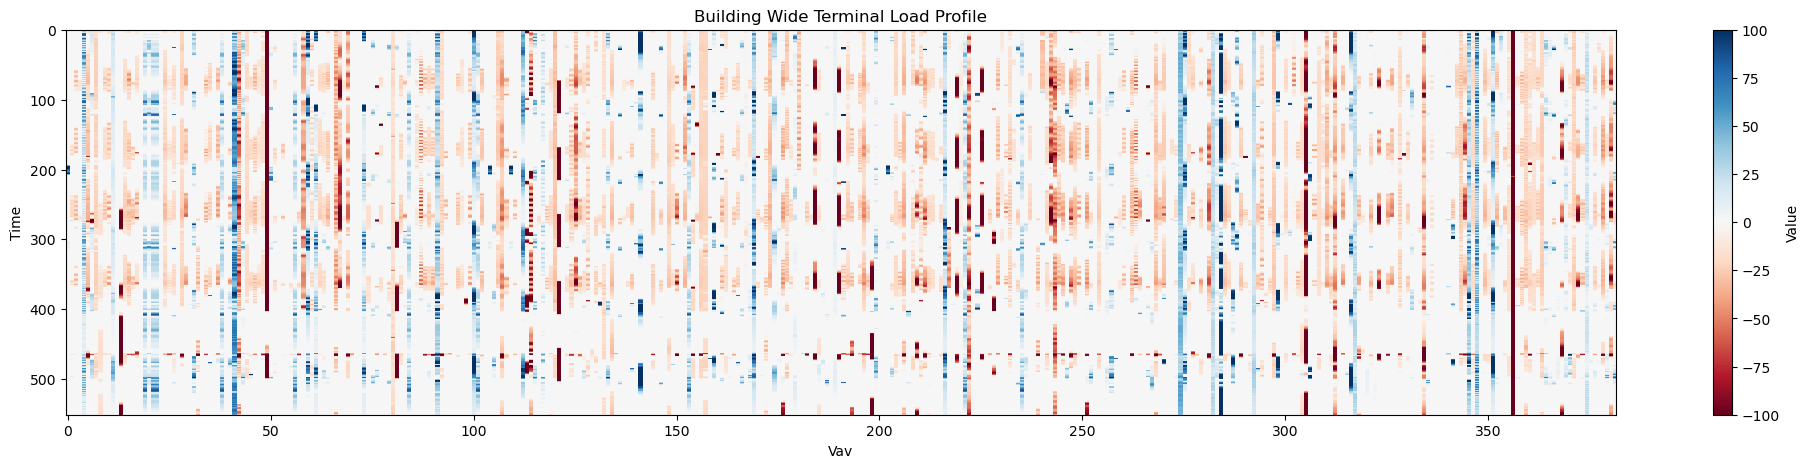

In [103]:
tload_viz(df.iloc[-2*concatenated_predictions.shape[0]:-concatenated_predictions.shape[0]], small=True)


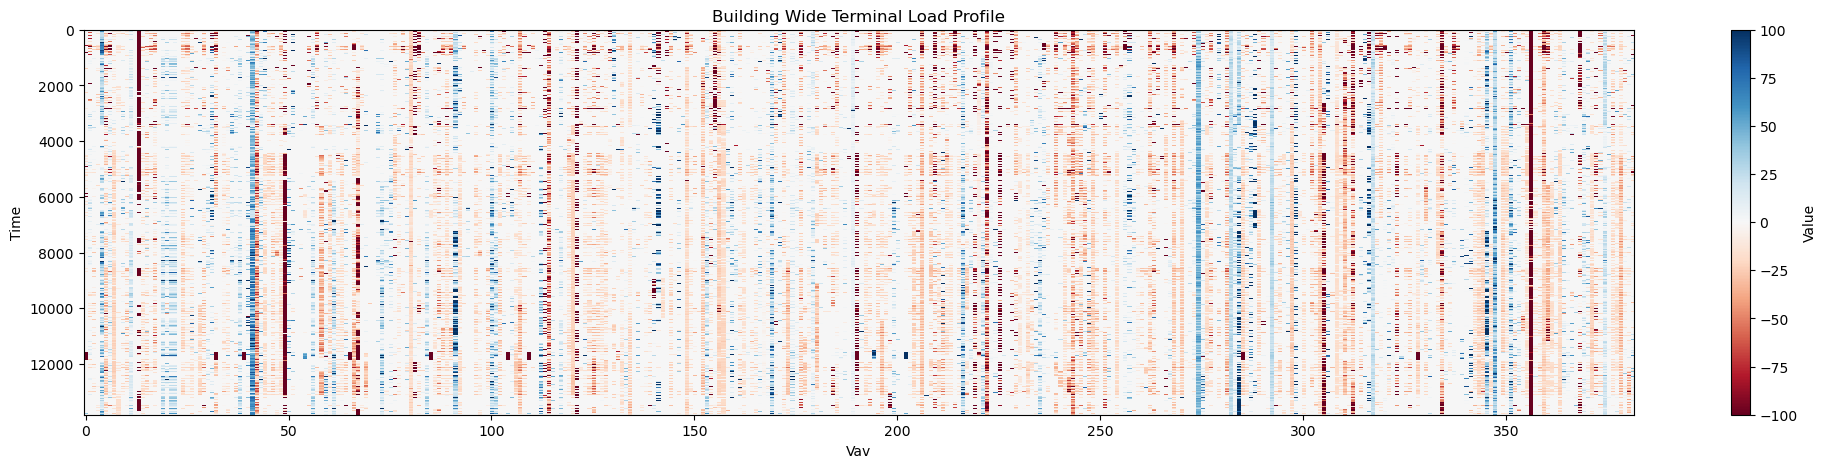

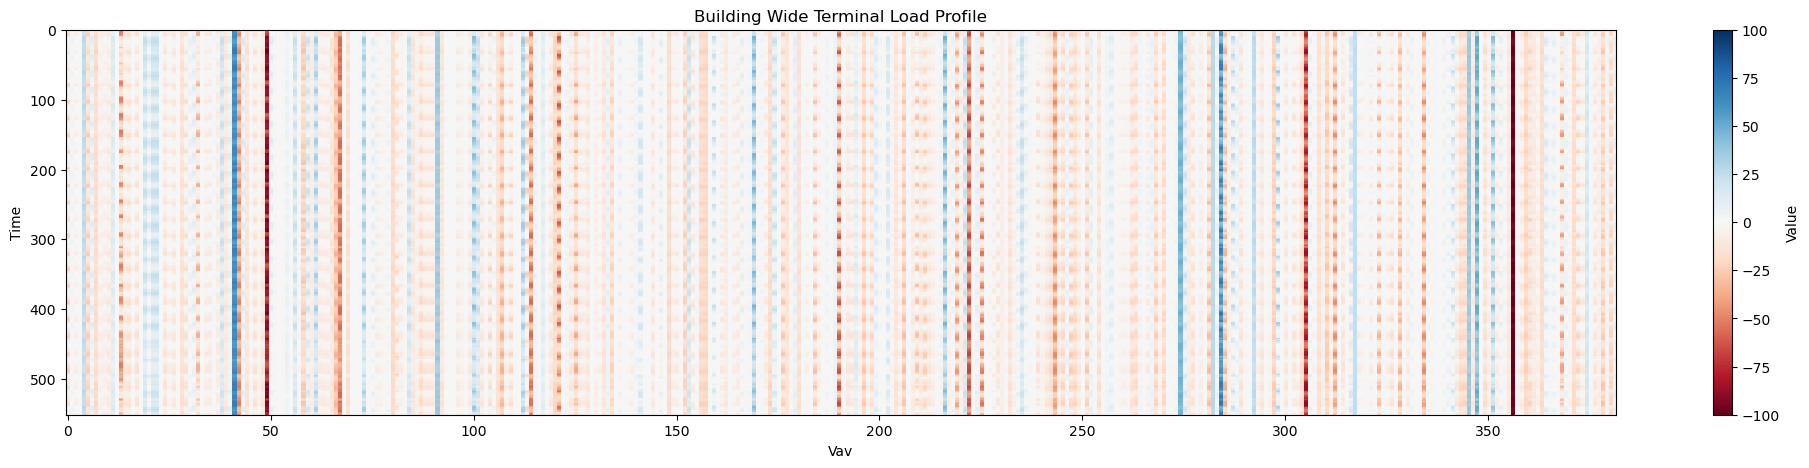

In [104]:
tload_viz(df.iloc[:], small=True)
tload_viz(predictions_df, small=True)

# Which zones are more variable?

In [105]:
variable_vav = df.map(lambda x: max(x,0)).std().sort_values().tail(10).index

In [106]:
variable_idxs = [df.columns.get_loc(var) for var in variable_vav]

In [107]:
variable_idxs

[100, 216, 351, 288, 141, 91, 316, 345, 298, 284]

In [108]:
variables_idx = df.columns.get_indexer(variable_vav)

<Axes: xlabel='Date'>

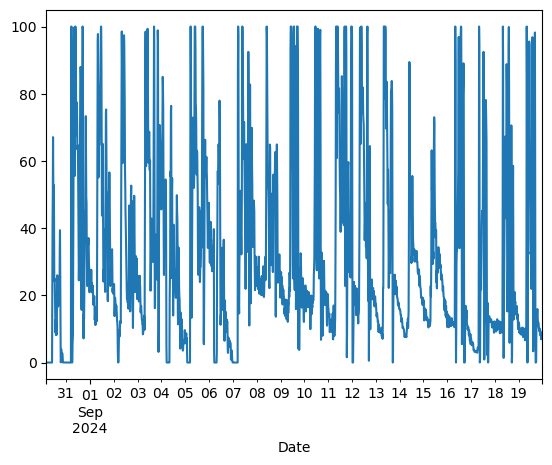

In [109]:
df.iloc[-2000:,216].plot()

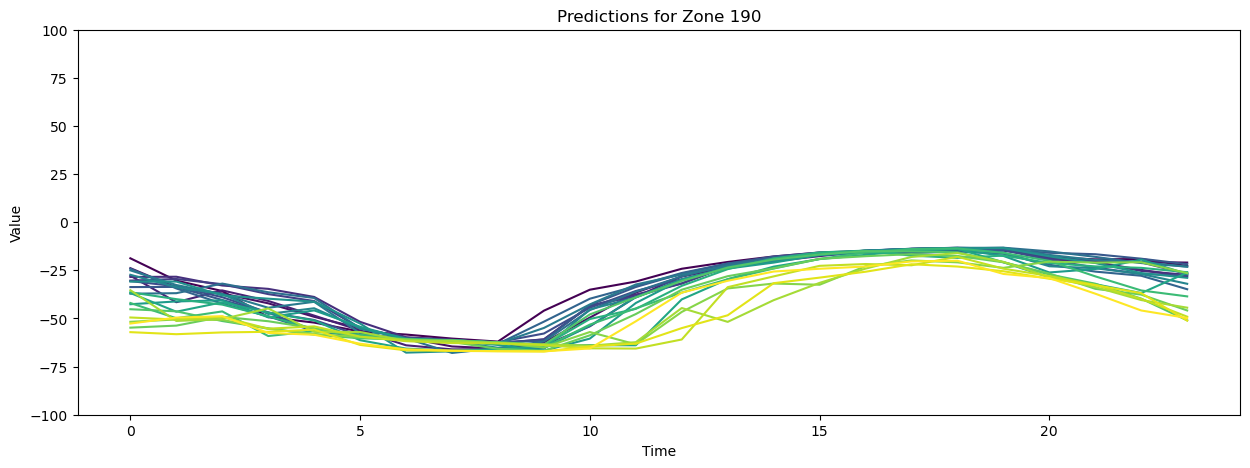

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_predictions is a 3D numpy array with shape (num_samples, num_timesteps, num_zones)
# Assuming you want to plot for zone 225

zone = 190
num_samples = all_predictions.shape[0]

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_samples))

plt.figure(figsize=(15, 5))
for sample in range(num_samples):
    plt.plot(all_predictions[sample, :, zone], color=colors[sample])

plt.ylim(-100, 100)
plt.title(f'Predictions for Zone {zone}')
plt.xlabel('Time')
plt.ylabel('Value')

# Create a ScalarMappable and add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_samples-1))
sm.set_array([])

plt.show()

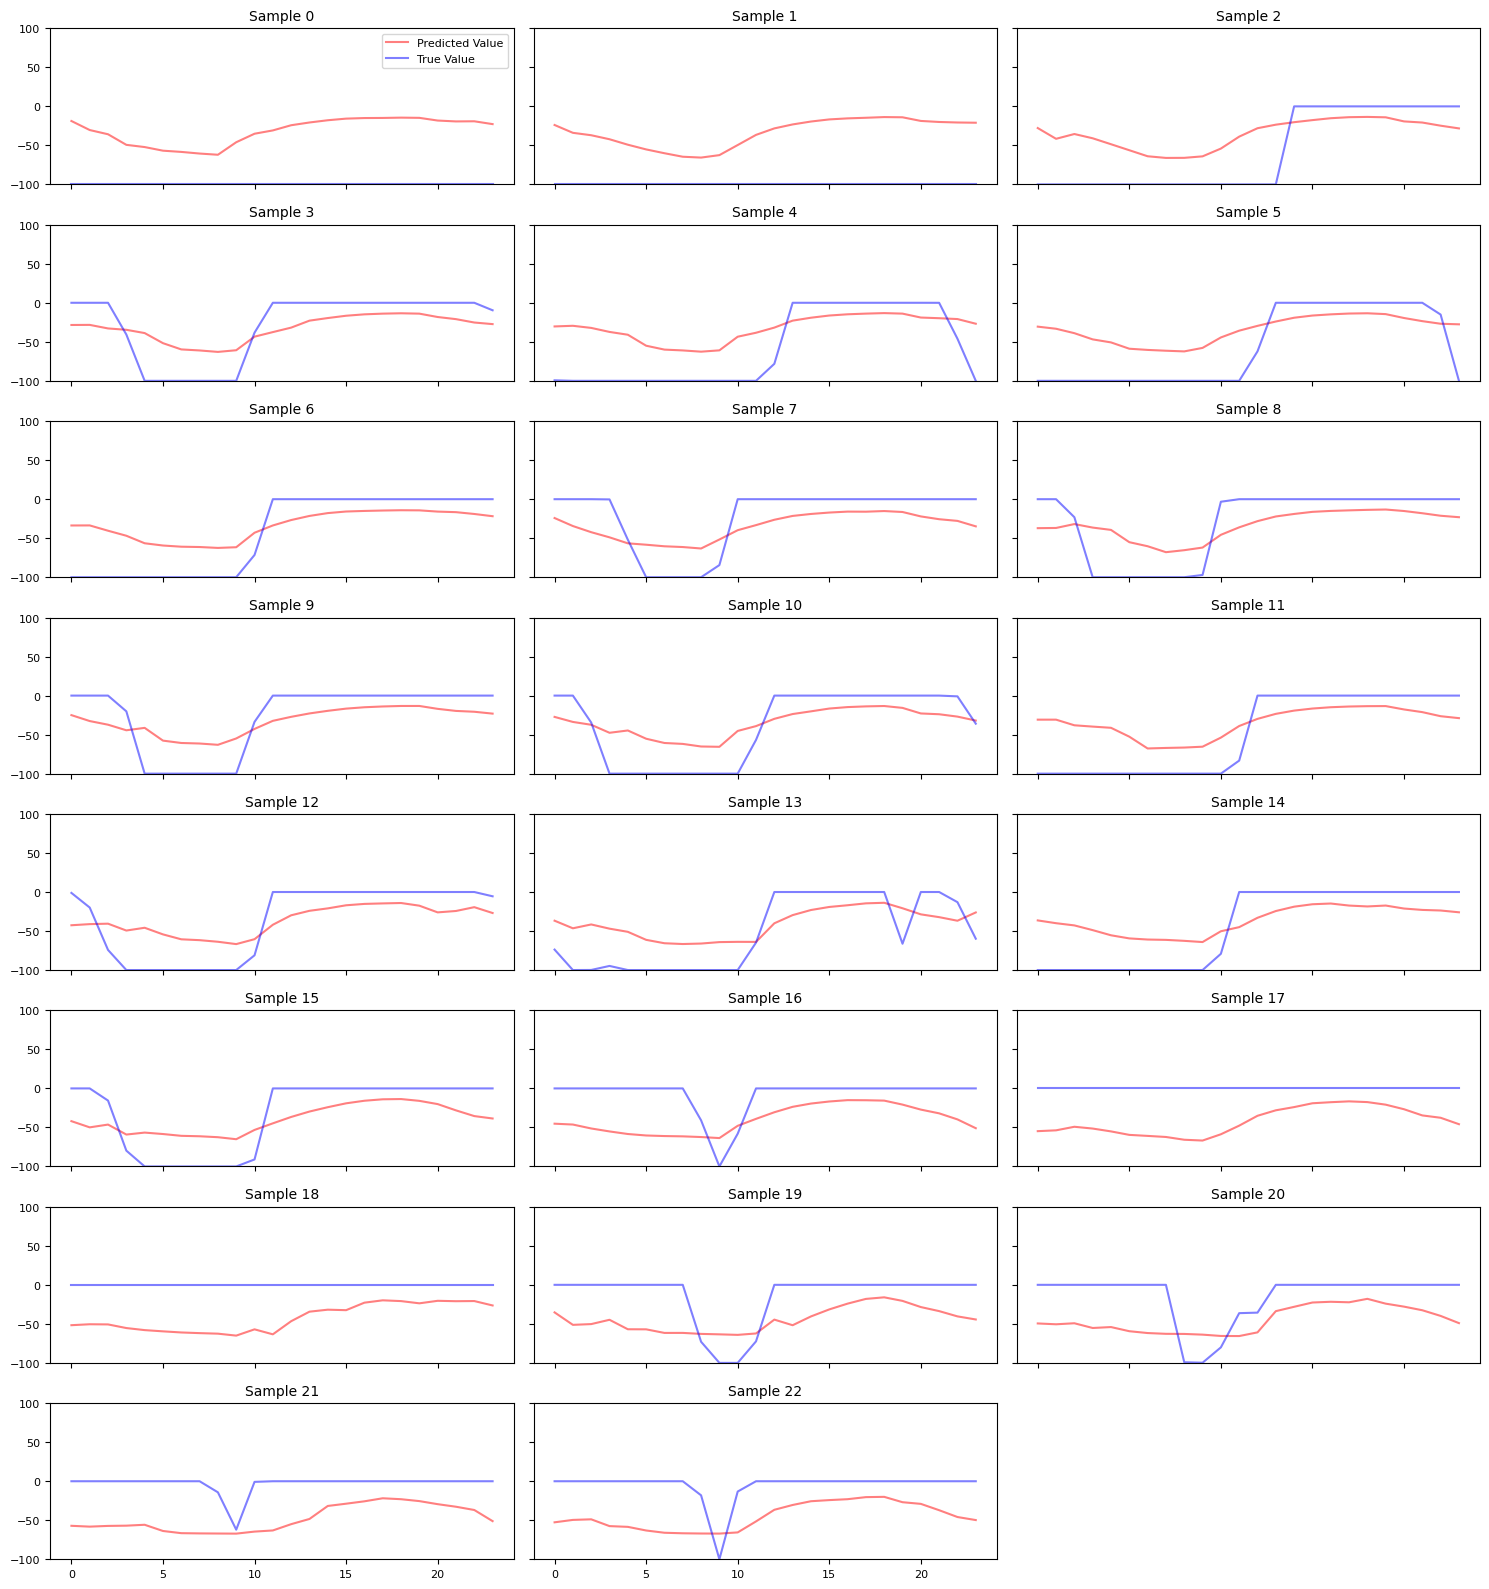

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_predictions and all_targets are 3D numpy arrays with shape (num_samples, num_timesteps, num_zones)
# Assuming you want to plot for zone 225

num_samples = all_predictions.shape[0]
samples_per_row = 3
num_rows = (num_samples + samples_per_row - 1) // samples_per_row  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, samples_per_row, figsize=(15, 2 * num_rows), sharex=True, sharey=True)

for sample in range(num_samples):
    row = sample // samples_per_row
    col = sample % samples_per_row
    axs[row, col].plot(all_predictions[sample, :, zone], label='Predicted Value', color='red', alpha=0.5)
    axs[row, col].plot(all_targets[sample, :, zone], label='True Value', color='blue', alpha=0.5)
    axs[row, col].set_ylim(-100, 100)
    axs[row, col].set_title(f'Sample {sample}', fontsize=10)
    axs[row, col].tick_params(axis='both', which='major', labelsize=8)
    if sample == 0:
        axs[row, col].legend(fontsize=8)

# Hide any empty subplots
for i in range(num_samples, num_rows * samples_per_row):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()